# Classification d'Images avec TensorFlow et transfert d'apprentissage
Ce notebook présente le pipeline complet d'entraînement d'un modèle de classification d'images basé sur MobileNetV2, incluant la préparation des données, l'augmentation, l'entraînement, l'évaluation et la prédiction.

## 1) Vérification GPU et Mixed-Precision
On vérifie la présence de GPU disponibles et on active le policy Mixed Precision pour accélérer les calculs.

In [21]:

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs trouvés :", gpus)
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)
tf.keras.mixed_precision.set_global_policy('mixed_float16')


GPUs trouvés : []


## 2) Définition des Hyper-paramètres
On définit les répertoires, tailles d'images, batch size, taux de validation, etc.

In [22]:

import os

DATA_DIR    = 'images'      # structure : images/CLASSE_X/*.jpg
IMG_SIZE    = (128, 128)    # résolution réduite → 4× plus rapide par passe
BATCH_SIZE  = 64            # plus gros batch tire mieux parti du GPU
VALID_SPLIT = 0.2
EPOCHS      = 12
AUTOTUNE    = tf.data.AUTOTUNE


## 3) Chargement des jeux de données (train & validation)
On utilise `image_dataset_from_directory` de Keras pour créer les datasets.

In [23]:

from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)
val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)
class_names = train_ds.class_names
print("Classes :", class_names)


Found 13000 files belonging to 26 classes.
Using 10400 files for training.
Found 13000 files belonging to 26 classes.
Using 2600 files for validation.
Classes : ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'clothing', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


## 4) Pipeline `tf.data` optimisé
On normalise les images, on met en cache, shuffle et prefetch pour optimiser le throughput.

In [24]:

def prep(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_ds = (
    train_ds.map(prep, num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(1000)
            .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds.map(prep, num_parallel_calls=AUTOTUNE)
          .cache()
          .prefetch(AUTOTUNE)
)


## 5) Data-augmentation
On ajoute flips, rotations et zoom pour rendre le modèle plus robuste.

In [25]:

from tensorflow.keras import layers, models

data_aug = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_aug(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)


## 6) Construction du modèle (MobileNetV2)
On utilise MobileNetV2 pré-entraîné, on ajoute un pooling global, dropout et une couche de sortie.

In [26]:

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax', dtype='float32')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=True
)


In [18]:
from tensorflow.keras import layers, models

# Modèle simple
inputs_simple = layers.Input(shape=IMG_SIZE + (3,))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs_simple)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs_simple = layers.Dense(len(class_names), activation='softmax')(x)

model_simple = models.Model(inputs_simple, outputs_simple)
model_simple.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_simple.summary()

from tensorflow.keras import callbacks

cb_simple = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Réduit le nombre d'epochs pour accélérer
EPOCHS_FAST = 3

history_simple = model_simple.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FAST,
    callbacks=cb_simple
)
model_simple.save("cnn_simple_tridechets_fast.h5")

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_14 (Cast)                  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │     4,194,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,196,090 (16.01 MB)

 Trainable params: 4,196,090 (16.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.0429 - loss: 7.2223 - val_accuracy: 0.0381 - val_loss: 3.2570 - learning_rate: 0.0010
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.0402 - loss: 3.2549 - val_accuracy: 0.0362 - val_loss: 3.2564 - learning_rate: 0.0010
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.0388 - loss: 3.2551 - val_accuracy: 0.0385 - val_loss: 3.2499 - learning_rate: 0.0010


## 7) Callbacks
On définit ReduceLROnPlateau et EarlyStopping pour ajuster le learning rate et stopper tôt si nécessaire.

In [27]:

from tensorflow.keras import callbacks

cb = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


## 8) Entraînement du modèle
On lance l'entraînement avec les datasets préparés et les callbacks.

In [28]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb
)
model.save("mobilenetv2_tridechets.h5")

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.2230 - loss: 3.1047 - val_accuracy: 0.6512 - val_loss: 1.2007 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 883ms/step - accuracy: 0.5373 - loss: 1.6328 - val_accuracy: 0.7123 - val_loss: 0.9705 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 904ms/step - accuracy: 0.6005 - loss: 1.3374 - val_accuracy: 0.7373 - val_loss: 0.8786 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 951ms/step - accuracy: 0.6302 - loss: 1.2667 - val_accuracy: 0.7385 - val_loss: 0.8532 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 928ms/step - accuracy: 0.6579 - loss: 1.1713 - val_accuracy: 0.7458 - val_loss: 0.8202 - learning_rate: 0.0010
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 920ms/step - accuracy: 0.6579 - loss: 1.1528 - val_accuracy: 0.7527 - val_loss: 0.8069 - learning_rate: 0.0010
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 157s 961ms/step - accuracy:

## 9) Évaluation du modèle
On génère un rapport de classification et une matrice de confusion sur le jeu de validation.

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

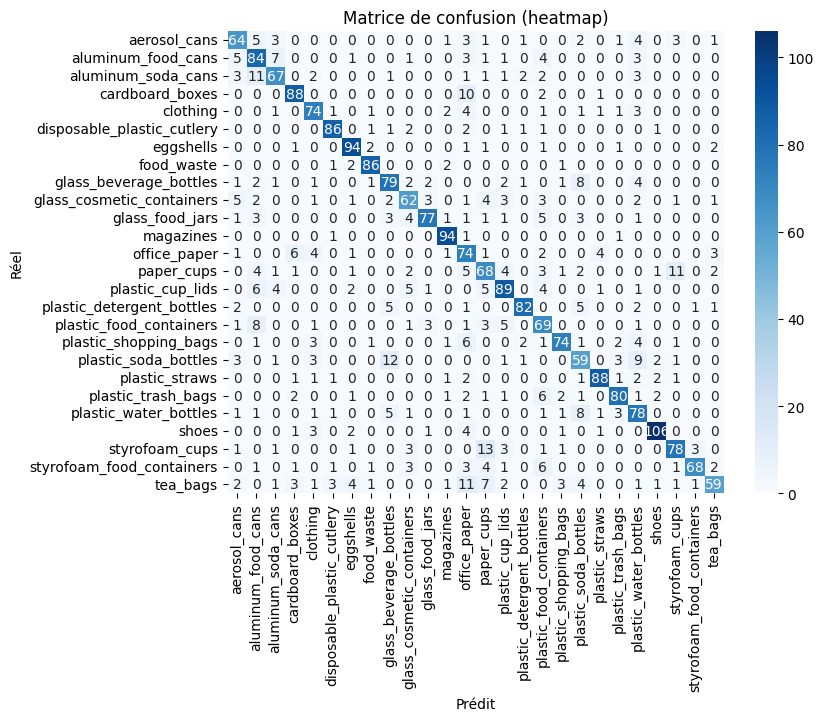

In [29]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des prédictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(np.concatenate([model.predict(x) for x, y in val_ds], axis=0), axis=1)

# Rapport et matrice
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
print("Matrice de confusion:\n", cm)

# Affichage heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion (heatmap)')
plt.show()


## 10) Prédiction
Fonction pour prédire la classe d'une nouvelle image.

In [ ]:

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(img_path, model, class_names):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.axis('off')
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    print(f"Classe prédite : {class_names[np.argmax(preds)]} (probabilité: {np.max(preds):.2f})")

# Exemple d'utilisation
predict_image("product-image-1695998361.webp", model, class_names)
